In [9]:
import os
import sys
import pdb
import copy
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import matplotlib as mpl
from matplotlib import rc
from datetime import datetime
from matplotlib import gridspec
import matplotlib.pyplot as plt
from cftime import DatetimeNoLeap as date
from matplotlib.dates import DateFormatter

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 14,   # Axis labels
    'xtick.labelsize' : 13,   # X-axis tick labels
    'ytick.labelsize' : 13,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)
#mpl.rc('text', usetex = True)
#mpl.rc('font', family = 'serif')

plt.ioff()

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)

<module 'compute_ensemble_stats' from '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC/compute_ensemble_stats.py'>

In [10]:
os.getenv('PATH')
os.environ["PATH"] += os.pathsep + '/global/homes/j/jhollo/miniconda3/bin/'

In [11]:
importlib.reload(putil)
importlib.reload(ces)

vargs = {'skip_nosrctag':True, 'mass':10, 'tmin':date(1991,6,1), 'tmax':date(1993,7,1), 'average_space':False, 'average_time':False}

# ----- get U data
#udat = putil.get_variable('U', skip_nosrctag=True)
udat = putil.get_variable('U', **vargs)

# ----- get dims
time, lat = udat['ensmean'].time, udat['ensmean'].lat
time = [datetime(t.year,t.month,t.day) for t in time.values]

# ----- set time limits
timelim = [time[0], datetime(time[0].year+2,time[0].month,time[0].day)]

# ----- set signifiance threshold
pcrit = 0.05
    
# ----- ploting settings
icmap       = 'RdBu_r' # impact colormap
isiglw      = 2.5      # significance contour linewidth
isigcolor   = 'w'      # significance contour color
ihatch      = '///'  # insignificance hatching type
ihatchlw    = 1        # insignificance hatching linewidth
ihatchcolor = 'w'      # insignificance hatching color
ucolor      = 'k'      # contour color for U
ulw         = 1.1      # line width for U contours
ulwz        = ulw*1.5  # line width for U zero-line
ualph       = 0.75     # alpha for U contours
eqcolor     = 'w'      # equator line color 
eqls        = '-'      # equator linestyle
eqlw        = 1.75      # equator line width
eqalph      = 0.66      # equator alpha
ercolor     = 'yellow' # eruption line color 
erls        = '-'      # eruption linestyle
erlw        = 2        # eruption line width
mpl.rcParams['hatch.linewidth'] = ihatchlw
mpl.rcParams['hatch.color']     = ihatchcolor


-------- processing ensemble zonal mean data...
merging data
ensemble members found: 15
doing temporal slicing and averaging...
doing spatial slicing and averaging...
data shape after member concat and slicing: (15, 180, 72, 152)
cf shape after member concat: and slicing (15, 180, 72, 152)
getting impact
getting data ensemble mean
getting cf ensemble mean
getting impact ensemble mean
getting ttest
getting coherence
done


In [12]:

def make_plot(ptype, ax, p, tsel=None, colorbar=False, legend=False):
    
    _, _, ax_wsize, ax_hsize = ax.get_position().bounds
    cbheight = 0.77
    cbpos    = [0.94, (1-cbheight)/2-0.005, 0.025, cbheight] # colorbar position
    
    # select data at pressure level or slice
    u = copy.deepcopy(udat)
    if(ptype == 'timelat'): 
        for ds in u.keys(): 
            u[ds]=u[ds].sel(plev=p, method='nearest')
        x, y = time, lat
        pp = lambda d: d.transpose('lat','time')
        latlim  = [-70, 70]
    if(ptype == 'latlev'):  
        for ds in u.keys(): 
            u[ds]=u[ds].sel(plev=p, time=tsel).mean('time').T
        x, y = lat, u['ensmean'].plev
        pp = lambda d: d.transpose('plev','lat')
        latlim  = [-90, 90]
    
    # --- plot ensemble data
    ax.contour(x, y, pp(u['cfmean']), colors=ucolor, linewidths=ulw, levels=ulev, alpha=ualph, zorder=10)
    ax.contour(x, y, pp(u['cfmean']), colors=ucolor, linewidths=ulwz, levels=[0], alpha=ualph, zorder=10)
    # --- plot impact data
    icf = ax.contourf(x, y, pp(u['impact']), cmap=icmap, levels=ilev, norm=inorm, extend='both') 
    # --- plot pval contours and hashing           
    ax.contourf(x, y, pp(u['pval']), levels=[pcrit, u['pval'].max()], hatches=[ihatch], colors='w',alpha=0)
    ax.contour(x, y, pp(u['pval']), colors=isigcolor, levels=[pcrit], linewidths=isiglw)

    if(ptype=='timelat'):
        # --- plot equator line
        ax.axhline(y=0, color=eqcolor, ls=eqls, lw=eqlw, alpha=eqalph, zorder=11)
        # --- plot eruption line
        ax.axvline(x=datetime(1991, 6, 15), color=ercolor, ls=erls, lw=erlw, zorder=12)
    if(ptype=='timelat'):
        # --- plot equator line
        ax.axvline(x=0, color=eqcolor, ls=eqls, lw=eqlw, alpha=eqalph, zorder=11)

    # ----- make colorbars
    if(colorbar):
        icbar = fig.colorbar(icf, cax=fig.add_axes(cbpos), orientation='vertical', location='right', extendrect=True)
        icbar.set_label('$\\overline{u}$ impact [m/s]', fontsize=15)
        icbar.set_ticklabels(np.array(ilev).astype(int))
        icbar.set_ticks(ilev)

    # ----- make legend
    if(legend):
        dummy = ax.plot([0,0],[0,0], color=ucolor, lw=ulw, alpha=ualph,label='counterfactual $\\overline{{u}}$ every {} m/s'.format(np.diff(ulev)[0]))
        #leg = ax.legend(bbox_to_anchor=(0.5, -2.35), frameon=True, fancybox=False, edgecolor='k', handlelength=1.5, fontsize=15, loc='center')
        leg = ax.legend(bbox_to_anchor=(1.01, -0.27), frameon=True, fancybox=False, edgecolor='k', handlelength=1.5, fontsize=15, loc='lower right')
        #leg = ax.legend(frameon=True, fancybox=False, edgecolor='k', handlelength=1.5, fontsize=15, loc='upper right')
        leg.get_frame().set_linewidth(0.66)

    # ----- make pressure label box
    if(ptype=='timelat'):
        ax.text(0.87, 0.19, '{} hPa'.format(p), transform=ax.transAxes, verticalalignment='top', fontsize=20, zorder=1000,
                bbox=dict(facecolor='w', edgecolor='k'))

    # ----- format
    if(ptype=='timelat'):
        ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80])
        ax.set_ylim(latlim)
        ax.set_xlim(timelim)
        putil.season_timeticks(ax, time, 'season', include_year=True)
        putil.format_lataxis(ax, which='y')
    if(ptype=='latlev'):
        ax.set_xticks([-60, -30, 0, 30, 60])
        ax.set_xlim(latlim)
        ax.set_ylim(y.min(), y.max())
        putil.format_lataxis(ax, which='x')
        putil.format_paxis(ax)

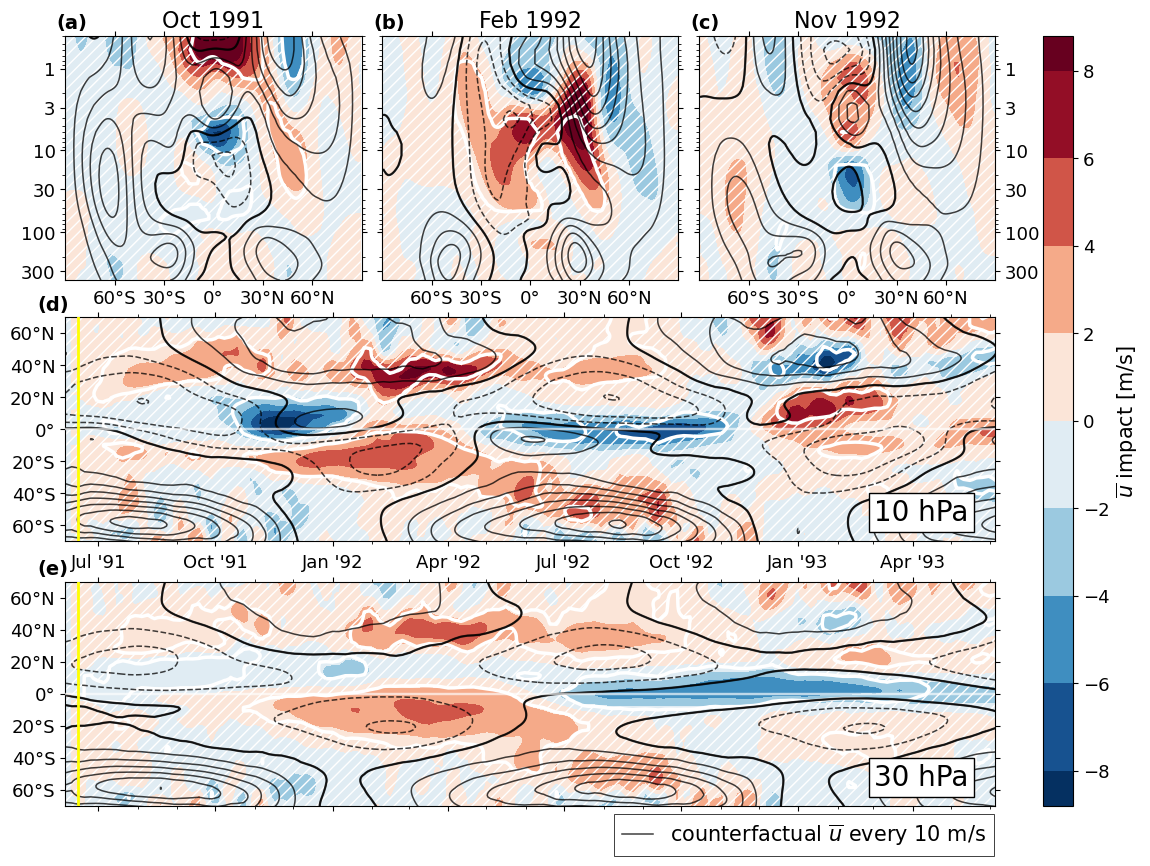

In [18]:
fig = plt.figure(figsize=(12,10))

gs  = gridspec.GridSpec(2, 1, height_ratios=[0.5,1], figure=fig, hspace=0.1)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.07)
gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1], hspace=0.18)

ax0 = fig.add_subplot(gs1[0,0])
ax1 = fig.add_subplot(gs1[0,1])
ax2 = fig.add_subplot(gs1[0,2])
ax3 = fig.add_subplot(gs2[0,0])
ax4 = fig.add_subplot(gs2[1,0])

# ----- configure U, U impact levels
ulev  = np.arange(-30, 100, 10)
ilev  = np.arange(-8, 9, 2)
inorm = putil.get_cmap_norm(ilev, 'twoslope')

# plot time-lat at levels
make_plot('latlev', ax0,  p=slice(0.3, 400), tsel=slice(date(1991,10,1), date(1991,11,1)))
make_plot('latlev', ax1,  p=slice(0.3, 400), tsel=slice(date(1992,2,1), date(1992,3,1)))
make_plot('latlev', ax2,  p=slice(0.3, 400), tsel=slice(date(1992,11,1), date(1992,12,1)))
make_plot('timelat', ax3, p=10, colorbar=True)
make_plot('timelat', ax4, p=30, legend=True)

# titles
ax0.set_title('Oct 1991', fontsize=16)
ax1.set_title('Feb 1992', fontsize=16)
ax2.set_title('Nov 1992', fontsize=16)

# format axes
putil.format_ticks(ax0)
putil.format_ticks(ax1, y=None)
putil.format_ticks(ax2, y='right')
putil.format_ticks(ax3, x=None)
putil.format_ticks(ax4, x='top')

# ---- subplot labels
letter = ['(a)','(b)','(c)','(d)', '(e)']
for i, axi in enumerate([ax0, ax1, ax2, ax3, ax4]):
    axi.annotate(letter[i], xy=(-0.03, 1.03), xycoords="axes fraction", fontsize=14, weight = 'bold')

plt.savefig('figs/impact_summary.pdf', dpi=250, bbox_inches='tight')
plt.show()